In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

/home/cfchio/miniconda3/envs/sk132/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = '23-01-sk132'
eval_set = [('test','./chcsj_test.csv'),
            ('pro','./chcsj_2024.csv'),
            ('ext','./kwh_ext.csv')]

In [3]:
# Load model
vot = joblib.load('./mo-ovary-'+model_name+'-vot.jb')
scaler = joblib.load('./mo-ovary-'+model_name+'-scaler.jb')
explainer = joblib.load('./mo-ovary-'+model_name+'-shap.jb')
train_mean = joblib.load('./mo-ovary-'+model_name+'-mean.jb')
cutoff = train_mean['cutoff']

# Features selected by LASSO
feature_names = ['Age','Menopause','US1','US2','US5','US6','US7','CA125','BUN','ALT','AAR','WBC','Lym','PLR']

In [4]:
result = []

for i, eval_ in enumerate(eval_set):
    df_eval = pd.read_csv(eval_[1])
    x_test = df_eval[feature_names]
    y_test = df_eval['Type_ID']

    for c in x_test.columns:
        x_test[c].fillna(train_mean[c], inplace=True)
    x_test = scaler.transform(x_test)

    proba_vt = vot.predict_proba(x_test)
    pred_vt = list(map((lambda a: 1 if a[1]>=cutoff else 0), proba_vt))
    pred_r4 = list(map((lambda a: 1 if a>=450 else 0), df_eval["RMI4"]))

    result.append(pd.DataFrame())
    result[i]['ID'] = list(df_eval['ID'])
    result[i]['Type'] = list(df_eval['Type'])
    result[i]['Type_ID'] = list(df_eval['Type_ID'])
    result[i]['VTP'] = proba_vt[:,1]
    result[i]['RMI4'] = list(df_eval['RMI4'])
    result[i]['VT'] = pred_vt
    result[i]['R4'] = pred_r4
    result[i].to_csv('./result_'+eval_[0]+'.csv', index=False)

Plot Confusion Matrix

In [7]:
def plot_cfm(pred_vt, pred_r4, true_label, axes, axes_y, cmap='Blues'):
    display_lbl = ["Benign", "Borderline /\nMalignant"]

    cfm1 = ConfusionMatrixDisplay.from_predictions(true_label, pred_vt, display_labels=display_lbl, ax=axes[axes_y,0], cmap=cmap, colorbar=False)
    cfm1.ax_.set_xlabel('')
    cfm1.ax_.set_ylabel('')
    if axes_y == 0:
        cfm1.ax_.set_title('Our model', fontsize=14)
        cfm1.ax_.set_ylabel('Test set', fontsize=12)
    elif axes_y == 1:
        cfm1.ax_.set_ylabel("Simulated prospective", fontsize=12)
    else:
        cfm1.ax_.set_ylabel("Ext. Val.", fontsize=12)

    cfm2 = ConfusionMatrixDisplay.from_predictions(true_label, pred_r4, display_labels=display_lbl, ax=axes[axes_y,1], cmap=cmap, colorbar=False)
    cfm2.ax_.set_xlabel('')
    cfm2.ax_.set_ylabel('')
    if axes_y == 0:
        cfm2.ax_.set_title('RMI-4', fontsize=14)

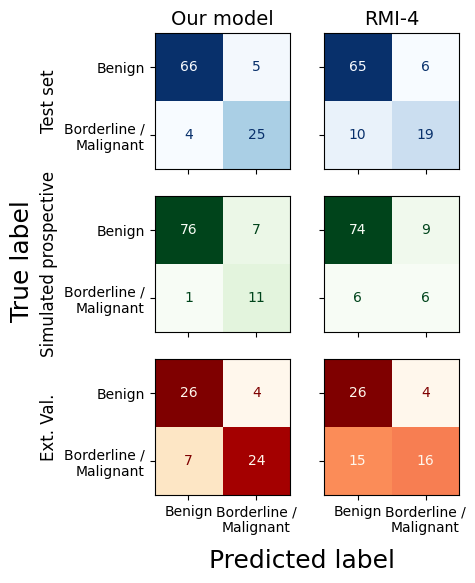

In [8]:
f, axes = plt.subplots(3, 2, figsize=(4, 6), sharey='row', sharex='col')
f.text(0.5, 0.0, 'Predicted label', ha='center', va='center', fontsize=18)
f.text(-0.2, 0.5, 'True label', ha='center', va='center', fontsize=18, rotation=90)

color = ['Blues', 'Greens', 'OrRd']
for i, r in enumerate(result):
    plot_cfm(r['VT'], r['R4'], r['Type_ID'], axes, i, color[i])

SHAP

In [7]:
df = pd.read_csv(eval_set[0][1])
x_test = df[feature_names]
for c in x_test.columns:
    x_test[c].fillna(train_mean[c], inplace=True)
x_test = scaler.transform(x_test)

In [8]:
shap_values = explainer.shap_values(x_test)

100%|██████████| 100/100 [10:52<00:00,  6.53s/it]


In [9]:
dfshap = pd.DataFrame(scaler.inverse_transform(x_test), columns=feature_names)

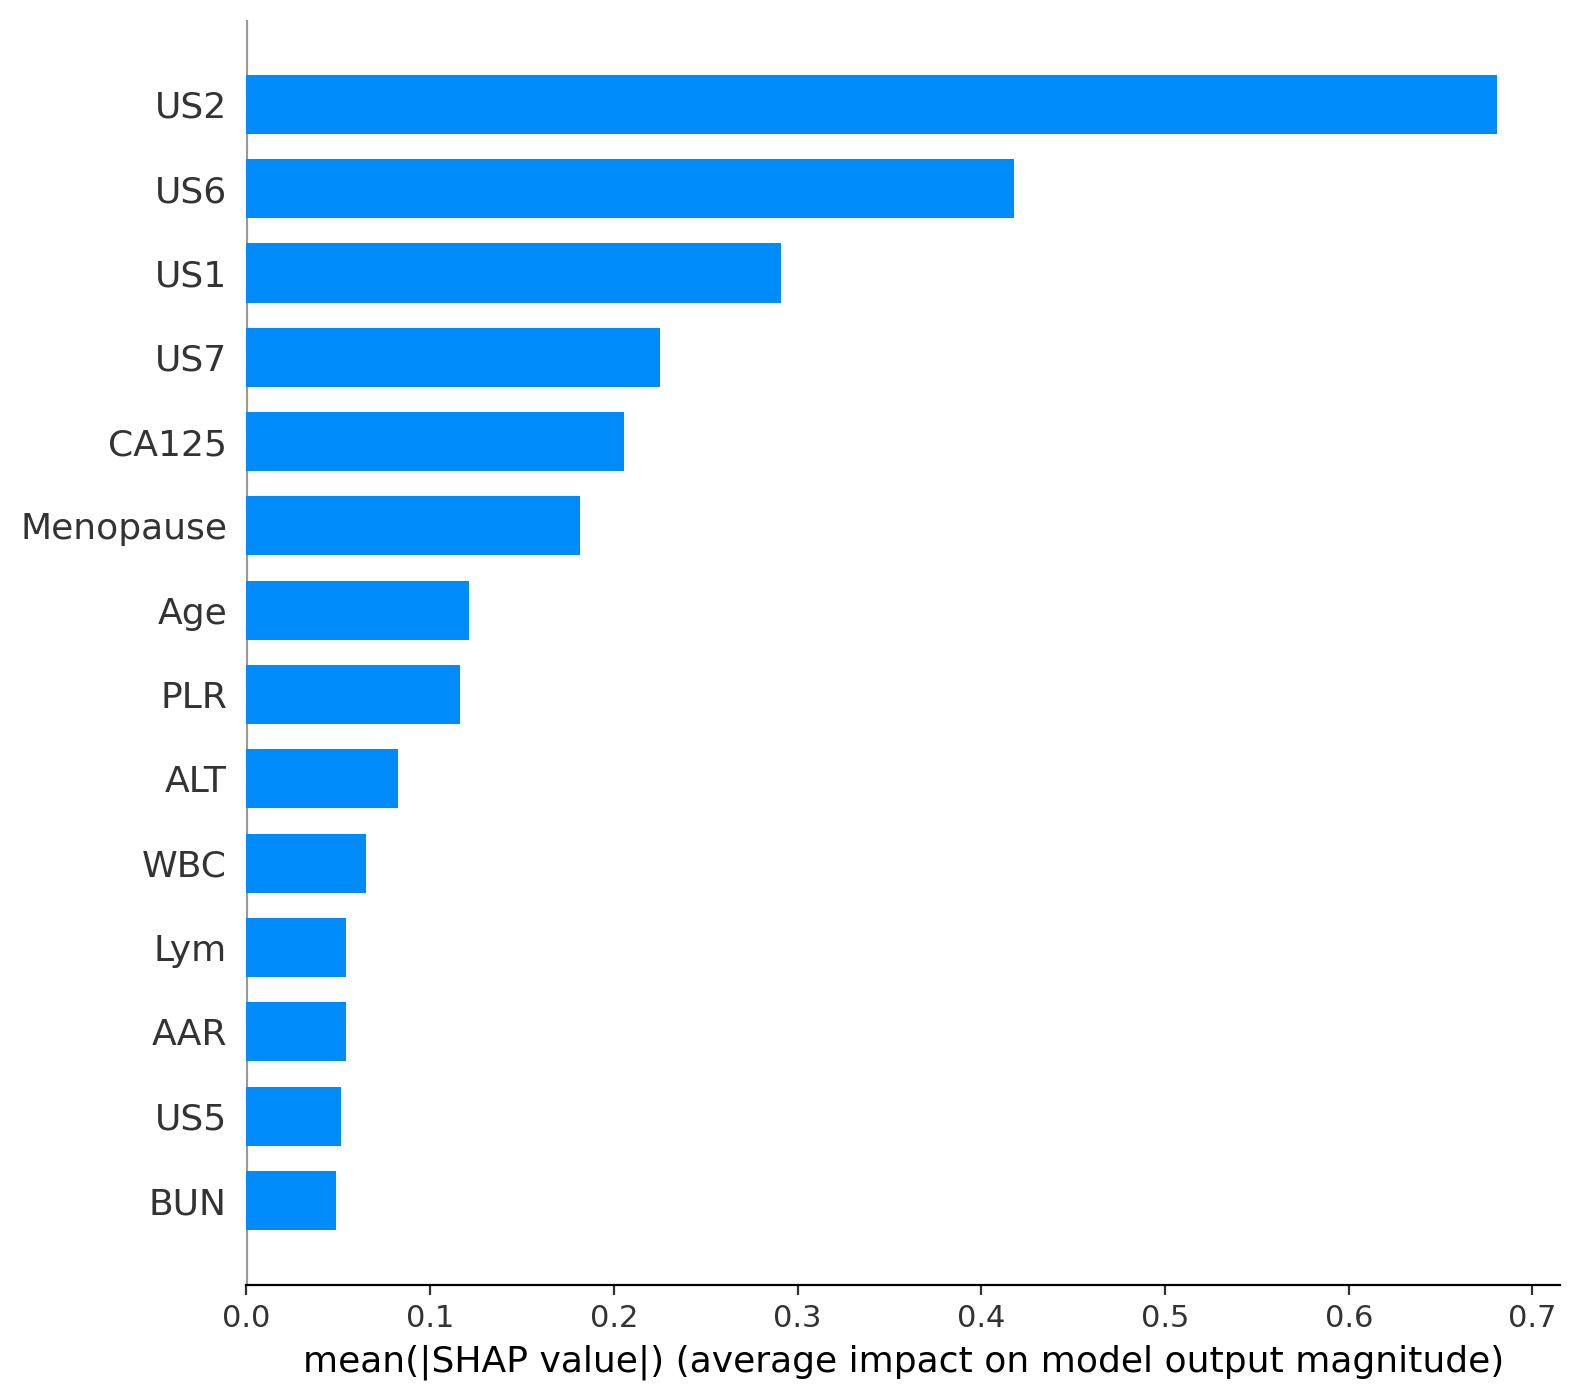

In [12]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_dpi(200)
shap.summary_plot(shap_values[:,:,1], dfshap, plot_type="bar")

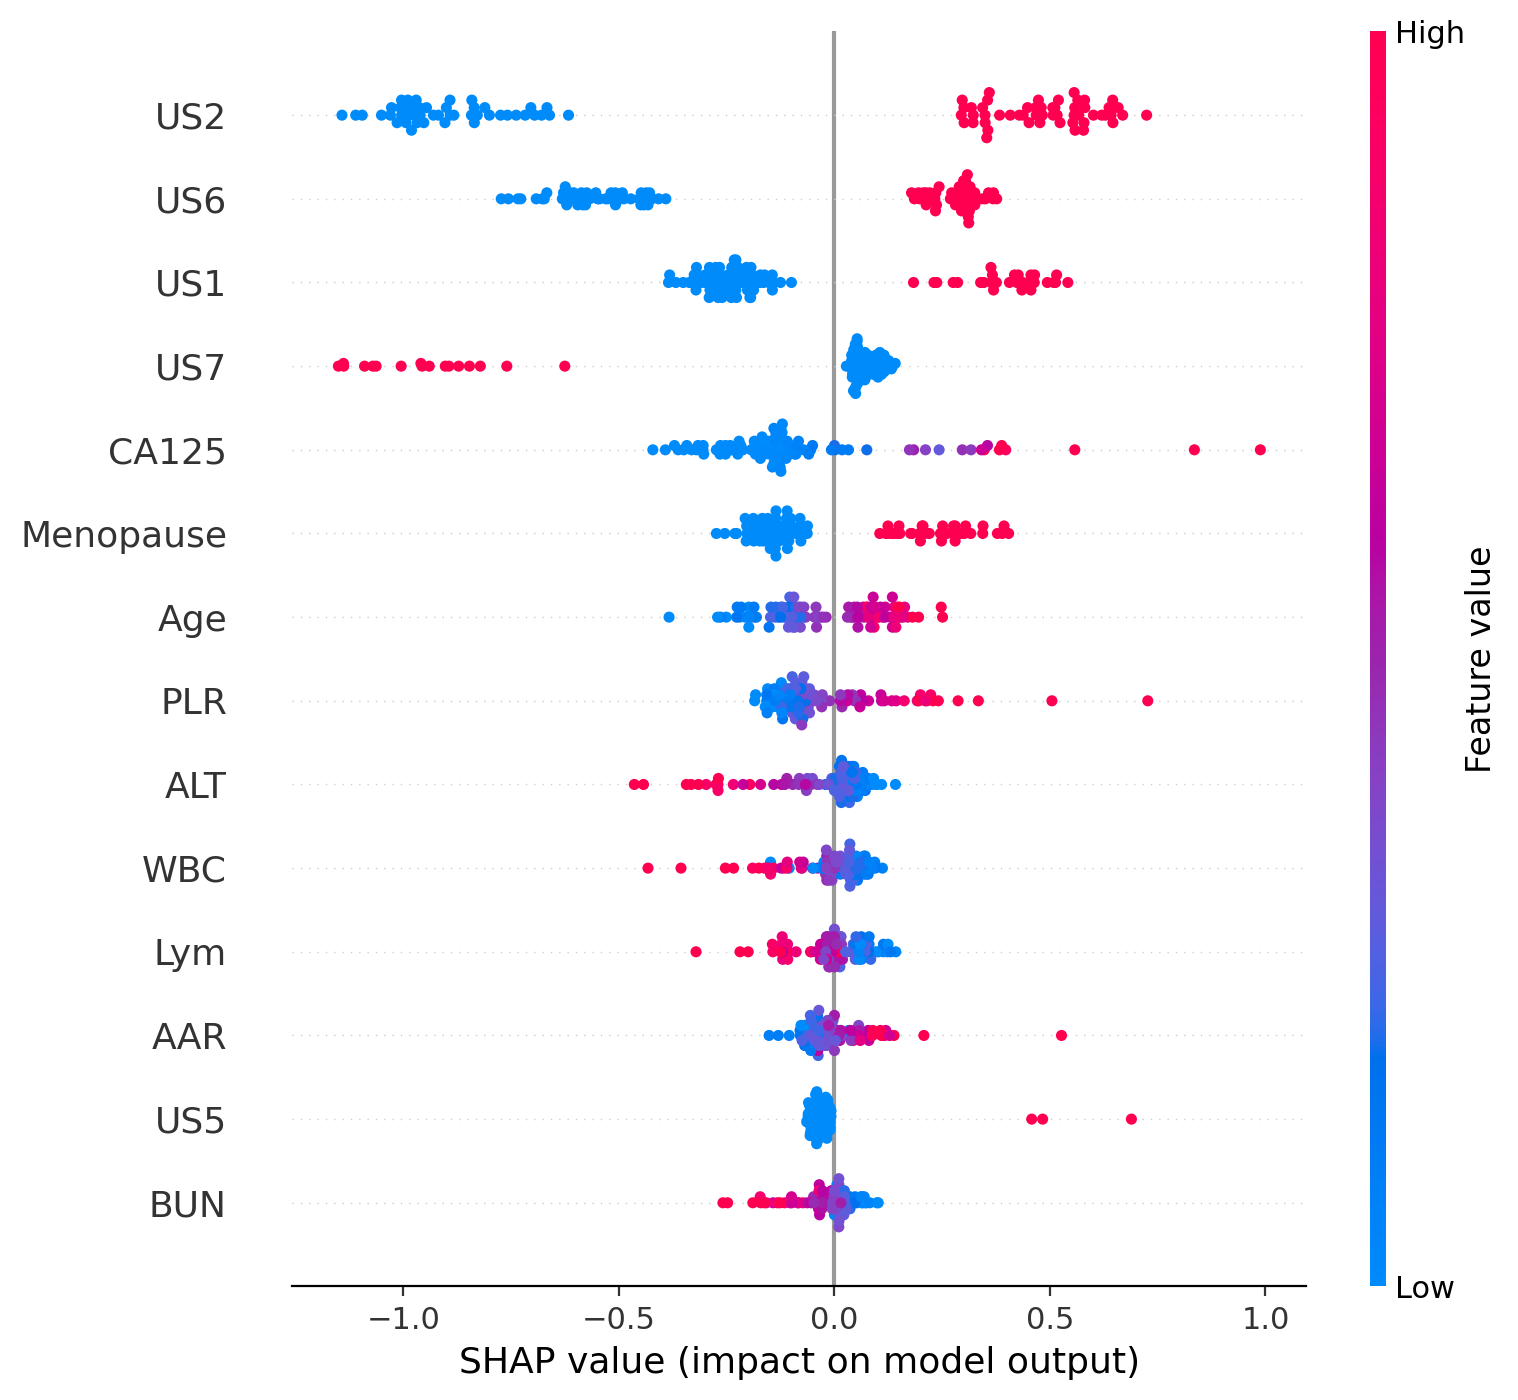

In [16]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_dpi(200)
shap.summary_plot(shap_values[:,:,1], dfshap)

In [17]:
shap.initjs()
index_to_explain = 76 #MP0006, sample case in figure 5
shap.force_plot(explainer.expected_value[1], shap_values[index_to_explain][:,1], dfshap.iloc[index_to_explain], link="logit")